In [1]:
import numpy as np
import scipy.stats
import scipy.signal
import random
import tensorflow as tf
import time
import os
import gym
from gym import envs, scoreboard
from gym.spaces import Discrete, Box
import tempfile
import sys
from PGActorContinuous import PGActorContinuous
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
print local_device_protos

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
bus_adjacency: BUS_ANY
incarnation: 781050821519783555
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 75169792
incarnation: 6514029718037741488
physical_device_desc: "device: 0, name: GeForce GT 750M, pci bus id: 0000:02:00.0"
]


In [2]:
# ==========================
#   Training Parameters
# ==========================
# Max training steps
MAX_EPISODES = 10000
# Max episode length
MAX_EP_STEPS = 2000
# Base learning rate for the Actor network
ACTOR_LEARNING_RATE = 0.01
CRITIC_LEARNING_RATE = 0.03
# Discount factor 
GAMMA = 0.96

# ===========================
#   Utility Parameters
# ===========================
# Render gym env during training
RENDER_ENV = True
# Use Gym Monitor
GYM_MONITOR_EN = True
# Gym environment
ENV_NAME = 'Pendulum-v0'
# # Directory for storing gym results
# MONITOR_DIR = './results/gym_ddpg'
# # Directory for storing tensorboard summary results
# SUMMARY_DIR = './results/tf_ddpg'
RANDOM_SEED = 1337
EPS_PER_BATCH = 10
FILTER_SIZE = 1

In [3]:
def discount(rewards):
    n_steps = len(rewards)
    empirical_values = np.zeros(n_steps)
    running_sum = 0
    for i in range(n_steps):
        running_sum = running_sum * GAMMA + rewards[n_steps-i-1]
        empirical_values[n_steps-i-1] = running_sum
    return empirical_values

In [4]:
def train(sess, env, actor):
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('Episode no.')
    ax.set_ylabel('Episode reward')
    ep_vals = []
    ax.set_xlim(0,MAX_EPISODES)
    ax.set_ylim(-100,300)

    # Initialize memory
    old_states, old_actions , old_advantages, old_returns = [], [], [], []
    nep_reward = 0
    nep_est_reward = 0
    for i in range(MAX_EPISODES):
#         env.render()
        s = env.reset()
        v = actor.predict_value(np.reshape(s, (1, -1)))[0]
        nep_est_reward += v
        ep_reward = 0
        returns = []
        values = []
        rewards = []
        for j in range(MAX_EP_STEPS):
            means_wrapped, stds = actor.predict(np.reshape(s, (1, -1)))
            means = means_wrapped[0]
            a = map((lambda mean, std : scipy.stats.truncnorm.rvs(a=(-actor.action_bound[0]-mean)/std,
                                                                  b=(actor.action_bound[0]-mean)/std,
                                                                  loc=mean,
                                                                  scale=std)),
                    means, stds)
            a = np.asarray(a)
            
            s2, r, is_done, info = env.step(a)

            # get new value prediction 
            v2 = actor.predict_value(np.reshape(s2, (1, -1)))[0]

            # add step to batch
            old_states.append(np.reshape(s, (actor.s_dim,)))
            old_actions.append(np.reshape(a, (actor.a_dim,)))
            values.append(v)
            rewards.append(r)
            
            s=s2
            v = v2
            ep_reward += r
            if is_done or j == MAX_EP_STEPS-1:
                break
        
        returns = np.expand_dims(discount(rewards), 1)
        advantages = -np.asarray(values) + returns
        old_advantages = old_advantages + advantages.tolist()
        old_returns = old_returns + returns.tolist()
        nep_reward += ep_reward
        ep_vals.append(ep_reward)
        
        if ax.lines:
            for line in ax.lines:
                y_data = scipy.signal.medfilt(ep_vals, [FILTER_SIZE])
                x_data = range(i+1)
                line.set_xdata(x_data)
                line.set_ydata(y_data)
        else:
            ax.plot(range(i+1), ep_vals)
        time.sleep(0.001)
        fig.canvas.draw()

        if i % EPS_PER_BATCH ==0 and i!=0:
                nep_reward=0
                nep_est_reward = 0

        if i% EPS_PER_BATCH==0 and i!=0:
            actor.train(old_states, old_actions, old_advantages)
            for n in range(50):    
                actor.train_value(old_states, old_returns)
            old_states =[]
            old_actions = []
            old_advantages = []   
            old_returns = []

[2016-11-30 02:48:22,488] Making new env: Swimmer-v1
[2016-11-30 02:48:22,783] tf.variable_op_scope(values, name, default_name) is deprecated, use tf.variable_scope(name, default_name, values)
[2016-11-30 02:48:22,854] tf.variable_op_scope(values, name, default_name) is deprecated, use tf.variable_scope(name, default_name, values)
[2016-11-30 02:48:22,926] tf.variable_op_scope(values, name, default_name) is deprecated, use tf.variable_scope(name, default_name, values)


state and actions dims: 8 2
Action bound: [ 1.  1.]
There are 13 actor params


[2016-11-30 02:48:23,917] tf.variable_op_scope(values, name, default_name) is deprecated, use tf.variable_scope(name, default_name, values)
[2016-11-30 02:48:23,990] tf.variable_op_scope(values, name, default_name) is deprecated, use tf.variable_scope(name, default_name, values)
[2016-11-30 02:48:24,067] tf.variable_op_scope(values, name, default_name) is deprecated, use tf.variable_scope(name, default_name, values)


There are 12 value params


<IPython.core.display.Javascript object>


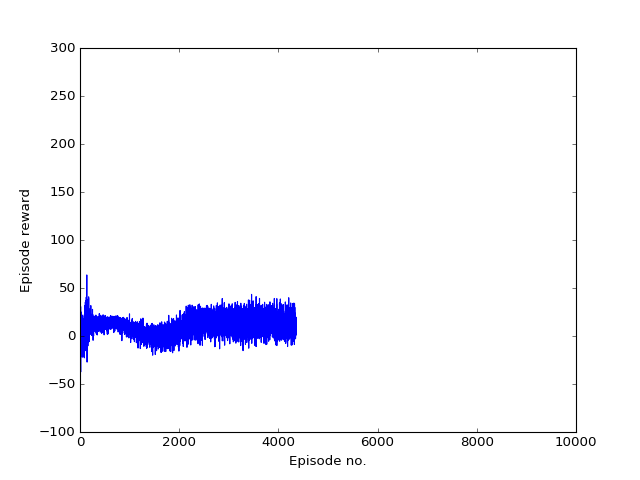

KeyboardInterrupt: 

In [5]:
# defining environment
sess = tf.Session()

env = gym.make('Swimmer-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
print "state and actions dims:", state_dim, action_dim

# make sure action bound is symmetric (can change in future,
# but need to remember to scale actor output appropriately)
assert (env.action_space.high == -env.action_space.low).all()

action_bound = env.action_space.high
print "Action bound:", action_bound
actor = PGActorContinuous(sess,state_dim, action_dim, action_bound, 
                 ACTOR_LEARNING_RATE, CRITIC_LEARNING_RATE)
# Initialize our Tensorflow variables
sess.run(tf.initialize_all_variables())


train(sess, env, actor)

In [11]:
plt.plot(range(len(ep_vals)), ep_vals)

NameError: name 'ep_vals' is not defined

In [8]:
def run(sess, env, actor, n_eps):
    nep_reward=0
    nep_est_reward = 0
    for i in range(n_eps):
        s=env.reset()
        ep_reward = 0
        for j in range(MAX_EP_STEPS):
            time.sleep(0.02)
            env.render()
            means_wrapped, stds = actor.predict(np.reshape(s, (1, -1)))
            means = means_wrapped[0]
            try:
                a = map((lambda mean, std : scipy.stats.truncnorm.rvs(a=(-actor.action_bound[0]-mean)/std,
                                                                  b=(actor.action_bound[0]-mean)/std,
                                                                  loc=mean,
                                                                  scale=std)),
                    means, stds)
            except:
                print stds
            a = np.asarray(a) 
            if not (np.abs(a) <=2.).all():
                print "!!!Action outside bounds!!!!"
                print "a =", a
                print "means =", means
                print "stds =", stds
            # get new state and reward
            s2, r, is_done, info = env.step(a)
        
            s=s2
            ep_reward += r
            
            if is_done or j == 200-1:
                nep_reward += ep_reward
                break
        
    print "| Avg undisc return (",n_eps,"eps):",  (int(nep_reward/n_eps)), \
    " | Avg est value (",n_eps,"eps):", nep_est_reward/n_eps
    print
    return nep_reward 
        

In [9]:
run(sess, env, actor, 5)

ValueError: invalid literal for int() with base 10: 'None'